# **Fine-Tune de Whisper Pour des termes médicaux en français**

Ecrit à partir de [https://huggingface.co/blog/fine-tune-whisper](https://huggingface.co/blog/fine-tune-whisper)

## Introduction

Whisper est un modèle pré-entraîné pour la reconnaissance automatique de la parole (ASR) publié en septembre 2022 par les auteurs Alec Radford et al. de l'OpenAI. Contrairement à nombre de ses prédécesseurs, tels que Wav2Vec 2.0, qui sont pré-entraînés sur des données audio non étiquetées, Whisper est pré-entraîné sur une grande quantité de données de transcription audio étiquetées, 680 000 heures pour être précis. Il s'agit d'un ordre de grandeur plus important que les données audio non étiquetées utilisées pour entraîner Wav2Vec 2.0 (60 000 heures). De plus, 117 000 heures de ces données de pré-entraînement sont des données ASR multilingues. Il en résulte des checkpoints qui peuvent être appliqués à plus de 96 langues, dont beaucoup sont considérées comme des langues à faibles ressources.

Cette quantité de données étiquetées permet à Whisper d'être pré-entraîné directement sur la tâche supervisée de reconnaissance de la parole, en apprenant une correspondance parole-texte à partir des données de pré-entraînement audio-transcription étiquetées 11. Par conséquent, Whisper ne nécessite que peu d'ajustements supplémentaires pour produire un modèle ASR performant. Contrairement à Wav2Vec 2.0, qui est pré-entraîné sur la tâche non supervisée de la prédiction masquée. Ici, le modèle est formé pour apprendre une correspondance intermédiaire entre la parole et les états cachés à partir de données audio non étiquetées. Bien que le pré-entraînement non supervisé produise des représentations de haute qualité de la parole, il ne permet pas d'apprendre une correspondance parole-texte. Cette correspondance n'est apprise qu'au cours du réglage fin, ce qui nécessite un réglage plus fin pour obtenir des performances compétitives.

Lorsqu'ils sont mis à l'échelle avec 680 000 heures de données de pré-entraînement étiquetées, les modèles Whisper démontrent une forte capacité à se généraliser à de nombreux ensembles de données et domaines. Les points de contrôle pré-entraînés obtiennent des résultats compétitifs par rapport aux systèmes ASR de pointe, avec un taux d'erreur de mot (WER) proche de 3% sur le sous-ensemble test-propre de LibriSpeech ASR et un nouvel état de l'art sur TED-LIUM avec un WER de 4,7% (cf. tableau 8 de l'article sur Whisper). La connaissance approfondie de l'ASR multilingue acquise par Whisper pendant le pré-entraînement peut être exploitée pour d'autres langues à faibles ressources ; grâce à un réglage fin, les points de contrôle pré-entraînés peuvent être adaptés à des ensembles de données et à des langues spécifiques afin d'améliorer encore ces résultats.

Whisper est un modèle de codage-décodage basé sur un transformateur, également appelé modèle séquence-séquence. Il établit une correspondance entre une séquence de caractéristiques de spectrogrammes audio et une séquence de mots-clés de texte. Tout d'abord, les entrées audio brutes sont converties en un spectrogramme log-Mel par l'action de l'extracteur de caractéristiques. L'encodeur Transformer encode ensuite le spectrogramme pour former une séquence d'états cachés de l'encodeur. Enfin, le décodeur prédit de manière autorégressive les mots-clés du texte, en fonction des mots-clés précédents et des états cachés du codeur.

La figure 1 résume le modèle Whisper.

![modèle Whisper](/home/lorcyr/Images/whisper_architecture.jpg "figure 1")


Figure 1 : Modèle Whisper. L'architecture suit le modèle standard de codeur-décodeur basé sur un transformateur. Un spectrogramme log-Mel est introduit dans le codeur. Les derniers états cachés du codeur sont transmis au décodeur via des mécanismes d'attention croisée. Le décodeur prédit de manière autorégressive les mots-clés du texte, en fonction des états cachés du codeur et des mots-clés prédits précédemment. Source de la figure : OpenAI Whisper Blog.

Dans un modèle séquence à séquence, le codeur transforme les entrées audio en un ensemble de représentations d'états cachés, en extrayant les caractéristiques importantes de la parole. Le décodeur joue le rôle d'un modèle linguistique, traitant les représentations d'états cachés et générant les transcriptions textuelles correspondantes. L'incorporation d'un modèle linguistique en interne dans l'architecture du système est appelée fusion profonde. Cela contraste avec la fusion superficielle, où un modèle linguistique est combiné de manière externe avec un codeur, comme avec CTC + nn-gram (c.f. Internal Language Model Estimation). Avec la fusion profonde, l'ensemble du système peut être entraîné de bout en bout avec les mêmes données d'entraînement et la même fonction de perte, ce qui offre une plus grande flexibilité et des performances généralement supérieures (c.f. ESB Benchmark).

Whisper est pré-entraîné et ajusté en utilisant la fonction objective de l'entropie croisée, une fonction objective standard pour l'entraînement des systèmes séquence-à-séquence sur des tâches de classification. Ici, le système est entraîné à classer correctement le jeton de texte cible à partir d'un vocabulaire prédéfini de jetons de texte.

Les versions de modèles Whisper(checkpoint) sont disponibles en cinq configurations de tailles de modèles différentes. Les quatre plus petits sont entraînés sur des données en anglais uniquement ou multilingues. Les checkpoints les plus grands sont uniquement multilingues. Les 11 checkpoints pré-entraînés sont disponibles sur le Hugging Face Hub. Les checkpoints sont résumés dans le tableau suivant avec des liens vers les modèles sur le Hub :

| Size     | Layers | Width | Heads | Parameters | English-only | Multilingual |
|----------|--------|-------|-------|------------|--------------|--------------|
| tiny     | 4      | 384   | 6     | 39 M       | ✓            | ✓            |
| base     | 6      | 512   | 8     | 74 M       | ✓            | ✓            |
| small    | 12     | 768   | 12    | 244 M      | ✓            | ✓            |
| medium   | 24     | 1024  | 16    | 769 M      | ✓            | ✓            |
| large    | 32     | 1280  | 20    | 1550 M     | x            | ✓            |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x            | ✓            |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x            | ✓            |


## Préparer l'environnement

Nous allons utiliser plusieurs packages Python populaires pour affiner le modèle Whisper. Nous utiliserons datasets[audio] pour télécharger et préparer nos données d'entraînement, ainsi que transformers et accelerate pour charger et entraîner notre modèle Whisper. Nous aurons également besoin du paquetage soundfile pour prétraiter les fichiers audio, evaluate et jiwer pour évaluer les performances de notre modèle, et tensorboard pour enregistrer nos métriques.
```sh
pip install --upgrade pip
pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard
```

Nous vous conseillons vivement de télécharger les checkpoints du modèle directement sur le Hugging Face Hub pendant l'entraînement. Au moins pour le premier entrainement.

### Préparation des datas

Nous avons besoins de fichiers audio et de leur transcriptions correctes.
Pour celà, nous avons mis dans un dossier data/ un dossier audio/, comprenant X fichiers .wav nommés par un nombre. Dans le repertoire rapports/, nous avons mis la correspondance écrite avec le même numero en format txt (unicode UTF-8)
Nous verrons plus bas que les audios seront entrainés dans un format particulié. Les avoir dans ce format dès le départ peut faire gagner du temps.

Une fois ces fichiers répartis dans leurs dossiers, nous avons a faire deux fichiers (train.csv et test.csv) qui vont répartir ces données entre les données d'entraînement et les données de test.
Voici un exmple de code faisant cela:

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the paths
audio_dir = 'data/audio'
text_dir = 'data/rapports'

# Create a list to hold the data
data = []

# Loop over each file in the audio directory
for audio_file in sorted(os.listdir(audio_dir)):
    if audio_file.endswith('.wav'):  # Assuming the audio files are in .wav format
        # Construct the corresponding text file path
        text_file = os.path.splitext(audio_file)[0] + '.txt'
        text_file_path = os.path.join(text_dir, text_file)
        
        # Read the transcription text if the file exists
        if os.path.exists(text_file_path):
            with open(text_file_path, 'r', encoding='utf-8') as f:
                transcription = f.read().strip()
        
            # Add the information to the data list
            data.append({
                'audio': os.path.join(audio_dir, audio_file),
                'sentence': transcription
            })

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Split the data into 80% train and 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the DataFrame to separate CSV files for train and test
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Train and Test CSV files created successfully.")

Nous avons réparti l'ensemble de nos datas en 80% pour l'entrainement et 20% pour le test.

Nous nous retrouvons donc avec des fichiers csv de la forme : 

nom_du_fichier_audio.wav, '*transcription*'


``` csv
audio,sentence
../data/audio/151.wav,"Le rapport biologique révèle une thyroïdite de Hashimoto caractérisée par une infiltration lymphocytaire et une fibrose diffuse, confirmant une pathologie auto-immune."
```

### Note sur la validité des données

Dans le principe, nous aurions besoins de véritable rapports médicaux avec les voix des personnels médicaux, les dictants. N'ayant pas encore cela, nous avons eu l'idée de faire faire nos "rapports" médicaux par un LLM (Mistral) et de les faire lire par le TextToSpeech BARK. Biensur la pertinence des textes médicaux issue de Mistral, peut être sujet à interrogation, mais rappelons que notre but est de faire reconnaitre des termes médicaux, et donc de faire "entendre" au modèle Whisper ces mots dans des contextes variés. Notre objectif est alors de montrer que le modèle s'améliore en ayant entendu ces mots. Passer à des textes réels et des voix humaines, ne peut qu'améliorer le modèle, tant dans par les contextes médicaux, plus "réels" que par les voix humaine.



#### Charger l'ensemble de données (**Dataset**)

In [ ]:
from datasets import load_dataset, DatasetDict

# Load the local CSV files for train and test sets
data_files = {
    "train": "data/train.csv",  # Local path to train.csv
    "test": "data/test.csv"     # Local path to test.csv
}

# Load the dataset from the local CSV files
dataset = DatasetDict()
dataset["train"] = load_dataset("csv", data_files={"train": data_files["train"]}, split="train")
dataset["test"] = load_dataset("csv", data_files={"test": data_files["test"]}, split="test")


print(dataset)

Notre version modèle (checkpoint) est celui de base d'openAI 

In [4]:
import torch
from transformers import WhisperForConditionalGeneration, WhisperTokenizer

model_name = "openai/whisper-base"
model = WhisperForConditionalGeneration.from_pretrained(model_name)
tokenizer = WhisperTokenizer.from_pretrained(model_name)

## Préparer l'extracteur de caractéristiques (Extractor), le tokenizer et les datas

Le pipeline ASR peut être décomposé en trois éléments :


1.   Un extracteur de caractéristiques qui pré-traite les entrées audio brutes
2.   Le modèle qui effectue le mappage séquence-séquence
3.   Un tokenizer qui post-traite les sorties du modèle au format texte.

Dans 🤗 Transformers, le modèle Whisper est associé à un extracteur de caractéristiques et à un tokenizer, appelés respectivement WhisperFeatureExtractor et WhisperTokenizer.

Nous allons détailler l'extracteur de caractéristiques et le tokenizer un par un !

**Charger l'extracteur de caractéristiques WhisperFeatureExtractor**

La parole est représentée par un tableau à une dimension qui varie avec le temps. La valeur du tableau à un pas de temps donné est l'amplitude du signal à ce moment-là. À partir des seules informations sur l'amplitude, nous pouvons reconstruire le spectre de fréquences de l'audio et récupérer toutes les caractéristiques acoustiques.

La parole étant continue, elle contient un nombre infini de valeurs d'amplitude. Cela pose des problèmes pour les appareils informatiques qui s'attendent à des tableaux finis. Nous discrétisons donc notre signal vocal en échantillonnant des valeurs de notre signal à des pas de temps fixes. L'intervalle avec lequel nous échantillonnons notre audio est connu sous le nom de taux d'échantillonnage et est généralement mesuré en échantillons/sec ou en Hertz (Hz). L'échantillonnage avec un taux d'échantillonnage plus élevé permet d'obtenir une meilleure approximation du signal vocal continu, mais nécessite également le stockage de plus de valeurs par seconde.

Il est essentiel de faire correspondre la fréquence d'échantillonnage de nos entrées audio à la fréquence d'échantillonnage attendue par notre modèle, car les signaux audio ayant des fréquences d'échantillonnage différentes ont des distributions très différentes. Les échantillons audio ne doivent être traités qu'avec la bonne fréquence d'échantillonnage. Le non-respect de cette règle peut entraîner des résultats inattendus ! Par exemple, si l'on prend un échantillon audio avec une fréquence d'échantillonnage de 16 kHz et qu'on l'écoute avec une fréquence d'échantillonnage de 8 kHz, l'audio sonnera comme s'il était en demi-vitesse. De la même manière, le passage d'un audio avec un taux d'échantillonnage incorrect peut faire échouer un modèle ASR qui s'attend à un taux d'échantillonnage et en reçoit un autre. L'extracteur de caractéristiques Whisper attend des entrées audio avec un taux d'échantillonnage de 16kHz, nous devons donc faire correspondre nos entrées à cette valeur. Nous ne voulons pas entraîner par inadvertance un système ASR sur de la parole au ralenti !

L'extracteur de caractéristiques Whisper effectue deux opérations. Tout d'abord, il compresse/tronque un lot d'échantillons audio de manière à ce que tous les échantillons aient une longueur d'entrée de 30 secondes. Les échantillons de moins de 30 secondes sont ramenés à 30 secondes en ajoutant des zéros à la fin de la séquence (les zéros dans un signal audio correspondent à l'absence de signal ou au silence). Les échantillons de plus de 30 secondes sont tronqués à 30 secondes. Étant donné que tous les éléments de la série sont complétés/tronqués à une longueur maximale dans l'espace d'entrée, nous n'avons pas besoin d'un masque d'attention lorsque nous transmettons les entrées audio au modèle Whisper. Whisper est unique à cet égard - avec la plupart des modèles audio, vous pouvez vous attendre à fournir un masque d'attention qui détaille où les séquences ont été remplies, et donc où elles doivent être ignorées dans le mécanisme d'auto-attention. Whisper est entraîné à fonctionner sans masque d'attention et à déduire directement des signaux vocaux où ignorer les entrées.

La deuxième opération effectuée par l'extracteur de caractéristiques de Whisper consiste à convertir les matrices audio en spectrogrammes log-Mel. Ces spectrogrammes sont une représentation visuelle des fréquences d'un signal, un peu comme une transformée de Fourier. Un exemple de spectrogramme est présenté à la figure 2. Le long de l'axe des ordonnées se trouvent les canaux Mel, qui correspondent à des bins de fréquence particuliers. Le long de l'axe xx se trouve le temps. La couleur de chaque pixel correspond à l'intensité logarithmique de ce groupe de fréquences à un moment donné. Le spectrogramme log-Mel est la forme d'entrée attendue par le modèle Whisper.

Les canaux de Mel (bins de fréquence) sont standard dans le traitement de la parole et choisis pour se rapprocher de la gamme auditive humaine. Tout ce que nous avons besoin de savoir pour le réglage fin de Whisper, c'est que le spectrogramme est une représentation visuelle des fréquences du signal de parole. Pour plus de détails sur les canaux Mel, voir le cepstre de fréquence Mel.

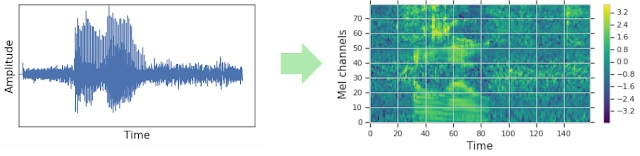
Figure 2 : Conversion d'un réseau audio échantillonné en spectrogramme log-Mel. À gauche : signal audio unidimensionnel échantillonné. À droite : spectrogramme log-Mel correspondant. Source de la figure : [Google SpecAugment Blog.](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html)

Heureusement pour nous, l'extracteur de caractéristiques 🤗 Transformers Whisper effectue à la fois le padding et la conversion du spectrogramme en une seule ligne de code ! Chargeons l'extracteur de caractéristiques à partir du point de contrôle pré-entraîné pour qu'il soit prêt pour nos données audio :

In [5]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)

## Load WhisperTokenizer
Voyons maintenant comment charger un tokenizer Whisper. Le modèle Whisper produit des jetons de texte qui indiquent l'index du texte prédit dans le dictionnaire des éléments de vocabulaire. Le tokenizer fait correspondre une séquence de jetons de texte à la chaîne de texte réelle (par exemple, [1169, 3797, 3332] -> « le chat s'est assis »).

Traditionnellement, lors de l'utilisation de modèles à encodeur seul pour l'ASR, nous décodons en utilisant la classification temporelle connexionniste ([CTC](https://distill.pub/2017/ctc/)). Dans ce cas, nous devons former un tokenizer CTC pour chaque ensemble de données que nous utilisons. L'un des avantages de l'utilisation d'une architecture codeur-décodeur est que nous pouvons directement exploiter le tokenizer du modèle pré-entraîné.

Le tokenizer Whisper est pré-entraîné sur les transcriptions des 96 langues de pré-entraînement. Par conséquent, il dispose d'une [paire d'octets](https://huggingface.co/course/chapter6/5?fw=pt#bytepair-encoding-tokenization) étendue qui convient à presque toutes les applications ASR multilingues. Pour l'hindi, nous pouvons charger le tokenizer et l'utiliser pour un réglage fin sans aucune autre modification. Il suffit de spécifier la langue cible et la tâche. Ces arguments indiquent au tokenizer de préfixer les tokens de la langue et de la tâche au début des séquences d'étiquettes encodées :

In [6]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name, language="French", task="transcribe")



> Conseil : l'article de blog peut être adapté à la traduction vocale en définissant la tâche sur traduire «*translate*» et la langue sur la langue du texte cible dans la ligne ci-dessus. Cela permettra d'ajouter à la tâche et à la langue les tokens nécessaires à la traduction vocale lors du prétraitement de l'ensemble de données.


Nous pouvons vérifier que le tokenizer encode correctement les caractères hindis en encodant et en décodant le premier échantillon de l'ensemble de données Common Voice. Lors de l'encodage des transcriptions, le tokenizer ajoute des « jetons spéciaux » au début et à la fin de la séquence, y compris les jetons de début/fin de transcription, le jeton de langue et les jetons de tâche (comme spécifié par les arguments à l'étape précédente). Lors du décodage des identifiants d'étiquettes, nous avons la possibilité de « sauter » ces jetons spéciaux, ce qui nous permet de renvoyer une chaîne dans la forme d'entrée originale :

In [ ]:
input_str = dataset["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")


## Combiner pour créer un WhisperProcessor

Pour simplifier l'utilisation de l'extracteur de caractéristiques et du tokenizer, nous pouvons les regrouper (*wrap*) dans une seule classe **WhisperProcessor**. Cet objet processeur **hérite** des classes **WhisperFeatureExtractor** et WhisperProcessor et peut être utilisé sur les entrées audio et les prédictions du modèle selon les besoins. Ce faisant, nous n'avons besoin de suivre que deux objets pendant l'apprentissage : le processeur et le modèle :

In [8]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name, language="French", task="transcribe")


**Préparer les données**

Imprimons le premier exemple de l'ensemble de données *medic* pour voir sous quelle forme se présentent les données :

In [ ]:
print(dataset["train"][0])


Nous pouvons voir que nous avons un tableau audio d'entrée à une dimension et la transcription cible correspondante. Nous avons beaucoup parlé de l'importance du taux d'échantillonnage et du fait que nous devons faire correspondre le taux d'échantillonnage de notre audio à celui du modèle Whisper (16kHz). Si notre audio d'entrée était échantillonné à 48kHz ou autre chose que 16Khz, nous devrions le re-échantillonner à 16kHz avant de le passer à l'extracteur de caractéristiques de Whisper.

Nous allons régler les entrées audio sur la fréquence d'échantillonnage correcte à l'aide de la méthode cast_column du jeu de données. Cette opération ne modifie pas l'audio sur place, mais signale aux datasets de rééchantillonner les échantillons audio à la volée la première fois qu'ils sont chargés :

In [10]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))


Le rechargement du premier échantillon audio dans l'ensemble de données *Medic* le rééchantillonnera à la fréquence d'échantillonnage souhaitée :

In [ ]:
print(dataset["train"][0])


Les valeurs du tableau peuvent être différentes.

Nous pouvons maintenant écrire une fonction pour préparer nos données pour le modèle :


1.   Nous chargeons et rééchantillonnons les données audio en appelant batch[« audio »]. Comme expliqué ci-dessus, 🤗 Datasets effectue toutes les opérations de rééchantillonnage nécessaires à la volée.
2.   Nous utilisons l'extracteur de caractéristiques pour calculer les caractéristiques d'entrée du spectrogramme log-Mel à partir de notre tableau audio unidimensionnel.
3.   Nous codons les transcriptions en identifiants d'étiquettes à l'aide du tokenizer.





In [12]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


Nous pouvons appliquer la fonction de préparation des données à tous nos exemples d'apprentissage en utilisant la méthode .map du jeu de données :

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=4)


Très bien ! Avec cela, nous avons nos données entièrement préparées pour l'entraînement ! Continuons et regardons comment nous pouvons utiliser ces données pour affiner Whisper.

> Note : Actuellement, les jeux de données utilisent à la fois torchaudio et librosa pour le chargement et le rééchantillonnage audio. Si vous souhaitez mettre en œuvre votre propre chargement/échantillonnage de données, vous pouvez utiliser la colonne « path » pour obtenir le chemin du fichier audio et ignorer la colonne « audio ».



## Training et Evaluation
Maintenant que nous avons préparé nos données, nous sommes prêts à nous plonger dans le pipeline de formation. Le 🤗 Trainer va faire le gros du travail à notre place. Tout ce que nous avons à faire, c'est :


*   Charger un point de contrôle pré-entraîné : nous devons charger un point de contrôle pré-entraîné et le configurer correctement pour l'entraînement.
*   Définir un collateur de données : le collateur de données prend nos données prétraitées et prépare des tenseurs PyTorch prêts pour le modèle.
* Métriques d'évaluation : lors de l'évaluation, nous voulons évaluer le modèle à l'aide de la métrique du taux d'erreur sur les mots (WER). Nous devons définir une fonction compute_metrics qui gère ce calcul.
* Définir les arguments de formation : ils seront utilisés par le 🤗 *Trainer* pour construire le programme de formation.

Une fois le modèle affiné, nous l'évaluerons sur les données de test afin de vérifier que nous l'avons correctement entraîné à transcrire des termes médicaux.

## Charger un point de contrôle pré-entraîné (Pre-Trained Checkpoint)
Nous commencerons notre cycle de réglage fin à partir du point de contrôle pré-entraîné de Whisper small. Pour ce faire, nous chargerons les poids pré-entraînés du Hugging Face Hub. Encore une fois, cette opération est triviale grâce à l'utilisation de 🤗 Transformers !

In [14]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_name)


Au moment de l'inférence, le modèle Whisper détecte automatiquement la langue de l'audio source et prédit les identifiants de jetons dans cette langue. Dans les cas où la langue de l'audio source est connue a-priori, comme dans le cas d'un réglage fin multilingue, il est avantageux de définir la langue de manière explicite. Cela permet d'éviter les scénarios dans lesquels la langue incorrecte est prédite, ce qui entraîne une divergence entre le texte prédit et la langue réelle au cours de la génération. Pour ce faire, nous définissons les arguments *language* et *task* dans la configuration de la génération.

In [15]:
model.generation_config.language = "french"
model.generation_config.task = "transcribe"

## Définir un collecteur de données (DataCollator)
Le collecteur de données pour un modèle vocal séquence à séquence est unique en ce sens qu'il traite les *input_features* et *labels* indépendamment : les caractéristiques d'entrée (*input_features*) doivent être traitées par l'extracteur de caractéristiques (*extractor*) et les étiquettes (*labels*) par le tokenizer.

Les *input_features* ont déjà été ramenés à 30 secondes et converties en un spectrogramme log-Mel de dimension fixe, de sorte qu'il ne nous reste plus qu'à les convertir en tenseurs PyTorch en lots. Nous le faisons en utilisant la méthode .pad de l'extractor avec return_tensors=pt. Notez qu'aucun rembourrage supplémentaire (*additional padding*)n'est appliqué ici puisque les entrées sont de dimension fixe, les *input_features* sont simplement convertis en tenseurs PyTorch.

En revanche, les *labels* ne sont pas tamponnés (*un-padded*). Nous commençons par ajouter un *pad* aux séquences jusqu'à la longueur maximale du lot à l'aide de la méthode .pad du tokenizer. Les jetons de remplissage (*padding tokkens*)sont ensuite remplacés par -100 afin que ces jetons ne soient pas pris en compte lors du calcul de la perte. Nous coupons ensuite le début du jeton de transcription du début de la séquence d'étiquettes, car nous l'ajouterons plus tard au cours de la formation.

Nous pouvons nous appuyer sur le **WhisperProcessor** que nous avons défini précédemment pour effectuer les opérations d'extraction de caractéristiques et de symbolisation :

In [18]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # diviser les entrées et les étiquettes, car elles doivent être de longueurs différentes et nécessitent des méthodes de remplissage différentes
        # traite d'abord les entrées audio en renvoyant simplement des tenseurs de torch
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Obtenir les séquences d'étiquettes symbolisées
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # Set the attention mask
        # create attention mask
        attention_mask = torch.ones(batch["input_features"].shape, dtype=torch.long)
        attention_mask[batch["input_features"] == 0] = 0

        batch["attention_mask"] = attention_mask
        batch["labels"] = labels

        return batch

Initialisons le collecteur de données que nous venons de définir :

In [19]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


## Métriques d'évaluation

Ensuite, nous définissons la métrique d'évaluation que nous utiliserons sur notre ensemble d'évaluation. Nous utiliserons le taux d'erreur de mots (WER), la métrique « de-facto » pour évaluer les systèmes ASR. Pour plus d'informations, consultez la [documentation](https://huggingface.co/metrics/wer) sur le WER. Nous chargerons la métrique WER à partir de 🤗 Evaluate :

In [20]:
import evaluate

metric = evaluate.load("wer")


Il suffit ensuite de définir une fonction qui prend les prédictions de notre modèle et renvoie la métrique WER. Cette fonction, appelée compute_metrics, remplace d'abord -100 par pad_token_id dans les labels_ids (annulant l'étape que nous avons appliquée dans le data collator pour ignorer correctement les tokens padded dans la perte). Il décode ensuite les identifiants prédits et d'étiquettes en chaînes de caractères. Enfin, il calcule le WER entre les prédictions et les étiquettes de référence :

In [17]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


## Définir les arguments de formation (Training Arguments)

Dans la dernière étape, nous définissons tous les paramètres liés à la formation. Un sous-ensemble de paramètres est expliqué ci-dessous :


* *output_dir* : répertoire local dans lequel enregistrer les poids du modèle. Ce sera également le nom du dépôt sur le Hugging Face Hub.
* *generation_max_length* : nombre maximal de tokens à générer de manière autorégressive pendant l'évaluation.
* *save_steps* : pendant la formation, les points de contrôle intermédiaires seront enregistrés et téléchargés de manière asynchrone vers le Hub tous les save_steps pas de formation.
* *eval_steps* : pendant la formation, l'évaluation des points de contrôle intermédiaires sera effectuée tous les eval_steps pas de formation.
* *report_to* : où enregistrer les journaux de formation. Les plateformes supportées sont « azure_ml », « comet_ml », « mlflow », « neptune », « tensorboard » et « wandb ». Choisissez votre plateforme préférée ou laissez « tensorboard » pour vous connecter au Hub.

Pour plus de détails sur les autres arguments d'entraînement, consultez la [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments) Seq2SeqTrainingArguments.

In [18]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-base-french-medic",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=700, #5000
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=25,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    run_name="essais_base",
    logging_dir="./whisper-base-french-medic/logs/essais_base"
)


**Note** : si l'on ne souhaite pas télécharger les points de contrôle du modèle vers le Hub, définir push_to_hub=False.

Nous pouvons transmettre les arguments d'entraînement au 🤗 Trainer avec notre modèle, notre jeu de données, notre collecteur de données et notre fonction compute_metrics :

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


Et voilà, nous sommes prêts à commencer l'entraînement !

## Formation (Training)

Pour lancer une formation, il suffit d'exécuter :

In [ ]:
torch.utils.checkpoint.use_reentrant = False
trainer.train()


L'entraînement a duré 5h37, et peut varier en fonction du modèle de base, de l'utilisation ou non d'un GPU ou de celui alloué au Google Colab si vous l'effectué avec. Il est possible que vous rencontriez une erreur CUDA « out-of-memory » lorsque vous commencez l'entraînement. Dans ce cas, vous pouvez réduire la taille du lot  (per_device_train_batch_size) par incréments d'un facteur 2 et utiliser les étapes d'accumulation du gradient (gradient_accumulation_steps) pour compenser.

On donne le nom de notre modèle entraîné et on le sauvegarde

In [ ]:
finetuned_directory = "./whisper-base-ch-perigueux"
model.save_pretrained(finetuned_directory)
processor.save_pretrained(finetuned_directory)

### Adaptation pour whisperLive
Pour notre reconnaissance en temps réel, nous utilisons les modèles faster-whisper, il nous faut donc les mettre dans ce format. Nous avons juste besoins de récupérer le tokenizer.json du modèle que l'on a entrainé et faire la transition par ctranslate2

In [ ]:
import os
import tokenizers

tokenizer_file = os.path.join(finetuned_directory, "tokenizer.json")
print(f"save  {tokenizer_file}", end="")
hf_tokenizer = tokenizers.Tokenizer.from_pretrained(model_name)
# Save the tokenizer to a file in the specified directory
hf_tokenizer.save(tokenizer_file)
print(" Ok")


In [ ]:
import shutil
import ctranslate2

# Chemin vers le dossier où le modèle est sauvegardé dans le format
output_dir = f"{finetuned_directory}-faster-whisper"

# Valeurs possibles pour quantization:

#     "int8" : Quantification en 8 bits pour réduire la taille du modèle, souvent utilisé pour les inférences sur CPU.
#     "int16" : Quantification en 16 bits, un compromis entre la vitesse et la précision.
#     "float16" : Utilisé pour les inférences sur GPU, où les calculs peuvent être effectués en 16 bits flottants.
quantization = "int16"

# Convertir le modèle en CTranslate2
converter = ctranslate2.converters.TransformersConverter(finetuned_directory)
converter.convert(output_dir, quantization=quantization, force=True)

print(f"Le modèle a été converti et sauvegardé dans {output_dir}")

shutil.copy(tokenizer_file, output_dir)
print(f"Fichier {tokenizer_file} copié dans {output_dir}")